In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon
import re

# Compute average bandwidth (given measured data)

In [117]:
dat_folder = 'data/edge/'
files = ['edge_' + str(i) + '.log' for i in range(20,160,20)]
avg_bandwidth = 0
n = 0
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
for file in files:
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                avg_bandwidth += values[1] / values[0]
                n += 1
avg_bandwidth = (avg_bandwidth * 10**-3) / n


# Delays

In [118]:
dat_folder = 'data/'
theoretical_bandwidth = 3.75 * 10**7 #byte/s
cloud_files = ['cloud/cloud_' + str(i) + '.log' for i in range(20,160,20)]
edge_files = ['edge/edge_' + str(i) + '.log' for i in range(20,160,20)]

clouds = {}
edges = {}

pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'

for file in cloud_files:
    scenario = file.split('_')[1][:-4]
    clouds[scenario] = []
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                clouds[scenario] += [values[1] / values[0]]

                
for file in edge_files:
    scenario = file.split('_')[1][:-4]
    edges[scenario] = []
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                edges[scenario] += [values[1] / values[0]]
                
df_clouds = pd.DataFrame(clouds).mean()
df_edges = pd.DataFrame(edges).mean()
ratio = df_edges/df_clouds

                
print(df_clouds)
print(df_edges)
print(ratio.mean()) #SLOWDOWN FACTOR OF CLOUD W.R.T. EDGE

20       949.832185
40      2993.546074
60      5455.239492
80      7529.297207
100     9275.280016
120    10555.726714
140    11549.831008
dtype: float64
20      6229.654131
40     18583.837656
60     32003.484684
80     41861.247174
100    50265.722367
120    57043.015471
140    51973.993123
dtype: float64
5.645183579750308


# Extract data for plot (no probabilistic delay)

In [119]:
dat_folder = 'data/'
files = ['3-pipelines-byte-policy.txt', '3-pipelines-latency-policy.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"




for i in range(0,len(files)): 
    run = [[] for _ in range(0,n_pipelines)]
    data[scenarios[i]] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            values = re.findall(pattern, l)
            values = [[float(num) for num in pair] for pair in values]
            zones = re.findall(zone_pattern,l)
            for j in range(0,len(values)):
                lat,size = values[j][0],values[j][1] 
                zone = zones[j]
                run[j] += [(lat,size,zone)]
        data[scenarios[i]] += [run]

for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario = df_run
    dfs_dict[scenario] = df_scenario


# Migration (no probabilistic delay)

    Latency (ms)  Size (MB)   Zone
0            0.0        0.0  cloud
1         2800.0       22.4  cloud
2          500.0       22.4   edge
3         1950.0       12.6  cloud
4         1950.0       12.6  cloud
5          200.0        1.4   edge
6         1100.0        1.4  cloud
7         7300.0       68.6  cloud
8         1300.0       68.6   edge
9         2800.0       22.4  cloud
10         500.0       22.4   edge
11        1950.0       12.6  cloud
12        1950.0       12.6  cloud
13         300.0        5.6   edge
14        1650.0        5.6  cloud
15        4750.0       50.4  cloud
16         850.0       50.4   edge


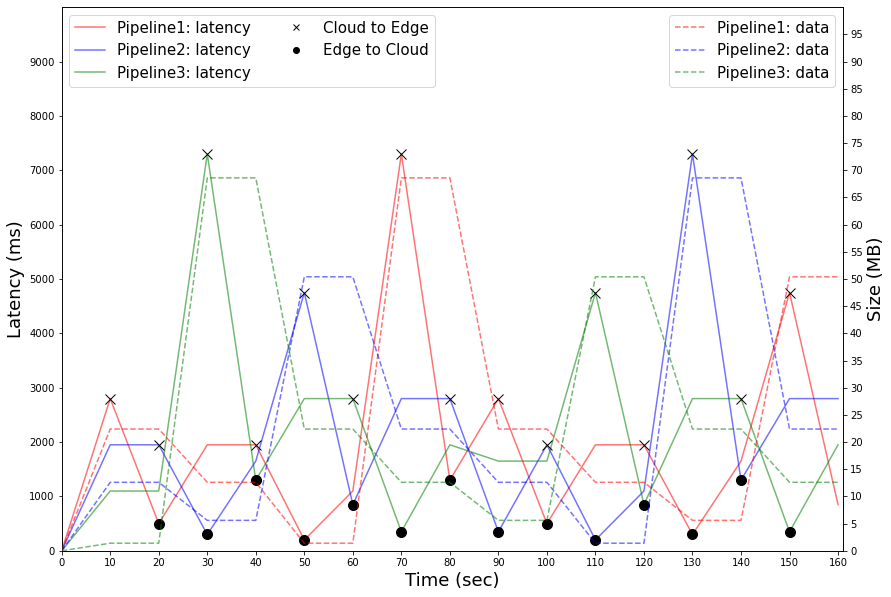

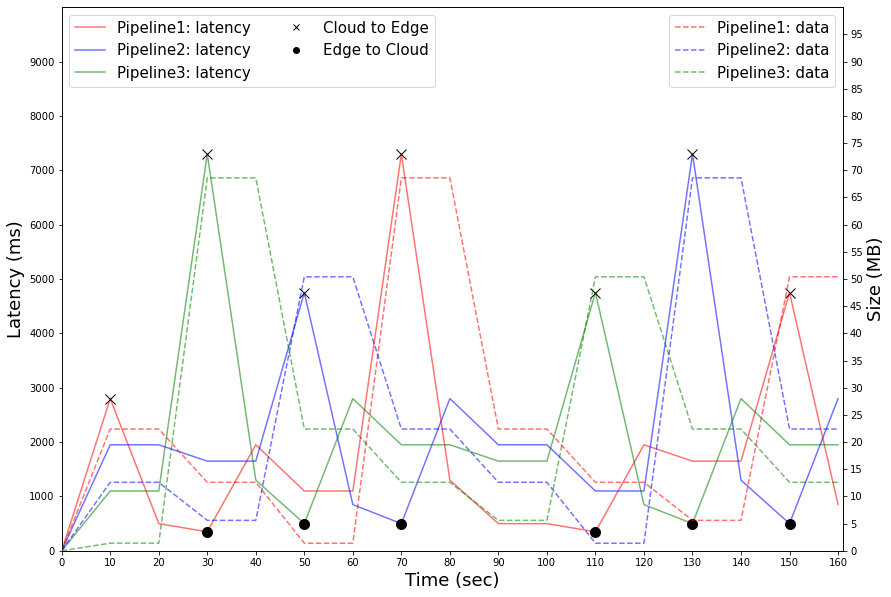

In [120]:
scenarios = ['3-pipelines-latency-policy', '3-pipelines-byte-policy']

print(dfs_dict[scenario][0])

x = [i*10 for i in range(0,len(dfs_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = dfs_dict[scenario][0]['Size (MB)']
    p2_byte = dfs_dict[scenario][1]['Size (MB)']
    p3_byte = dfs_dict[scenario][2]['Size (MB)']
    p1_lat = dfs_dict[scenario][0]['Latency (ms)']
    p2_lat = dfs_dict[scenario][1]['Latency (ms)']
    p3_lat = dfs_dict[scenario][2]['Latency (ms)']
    
    swaps[scenario] = [0 for _ in range(0,n_pipelines)]

    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)

    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
    
    ###swap points#####

    # x (cloud -> edge) o (edge -> cloud)
    ms = 7
    pipeline_index = 0
    for pipeline in dfs_dict[scenario]:
        last_zone = 'cloud'
        for i in range(0,len(pipeline)):
            curr_zone = pipeline['Zone'][i]
            if(curr_zone != last_zone):
                swaps[scenario][pipeline_index] +=  1
                lat = pipeline['Latency (ms)'][i-1]
                ax.plot(x[i-1], lat, linewidth=100000, marker= "x" if curr_zone == "edge" else "o", markersize=ms+3, markeredgecolor="black", markerfacecolor="black", zorder=10000)
                last_zone = curr_zone
        pipeline_index += 1
    ax.plot([],[],'x',label="Cloud to Edge", color='black')
    ax.plot([],[],'o',label="Edge to Cloud", color='black')

    
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)

In [121]:
for scenario in scenarios:
    print("###" + scenario + "###")
    mean_area = 0
    mean_lat = 0
    for i in range(0,len(dfs_dict[scenario])):
        area = np.trapz(dfs_dict[scenario][i]['Latency (ms)'], dx=5)
        avg_lat = sum(dfs_dict[scenario][i]['Latency (ms)'] / len(dfs_dict[scenario][i]['Latency (ms)']))
        mean_lat += avg_lat
        mean_area += area
        print("PIPELINE " + str(i) + " AUC = " + str(area) + ", AVG Latency = " + str(avg_lat) + ", SWAPS = " + str(swaps[scenario][i]))

    print("MEAN AUC: " + str(mean_area / len(dfs_dict[scenario])) + ", MEAN AVG = " + str(mean_lat / len(dfs_dict[scenario])))
    

###3-pipelines-latency-policy###
PIPELINE 0 AUC = 157125.0, AVG Latency = 1873.529411764706, SWAPS = 11
PIPELINE 1 AUC = 167250.0, AVG Latency = 2050.0, SWAPS = 10
PIPELINE 2 AUC = 172625.0, AVG Latency = 2088.2352941176473, SWAPS = 8
MEAN AUC: 165666.66666666666, MEAN AVG = 2003.921568627451
###3-pipelines-byte-policy###
PIPELINE 0 AUC = 140875.0, AVG Latency = 1682.3529411764705, SWAPS = 5
PIPELINE 1 AUC = 163500.0, AVG Latency = 2005.8823529411768, SWAPS = 4
PIPELINE 2 AUC = 165625.0, AVG Latency = 2005.8823529411768, SWAPS = 4
MEAN AUC: 156666.66666666666, MEAN AVG = 1898.0392156862747


# Extract Birex data for plot (probabilistic delay)

In [122]:
dat_folder = 'data/'
files = ['birex-byte-policy-20runs.txt', 'birex-latency-policy-20runs.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"


swaps_dict = {}


for i in range(0,len(files)): 
    run = [[] for _ in range(0,n_pipelines)]
    scenario = scenarios[i]
    swaps_dict[scenario] = [0 for _ in range(0,n_pipelines)]
    last = ['cloud' for _ in range(0,n_pipelines)]
    data[scenario] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                last = ['cloud' for _ in range(0,n_pipelines)]
                data[scenarios[i]] += [run]
                run = [[] for _ in range(0,n_pipelines)]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                for j in range(0,len(values)):
                    lat,size = values[j][0],values[j][1] 
                    zone = zones[j]
                    if zone != last[j]:
                        swaps_dict[scenario][j] += 1
                        last[j] = zone
                    if 'birex' in scenarios[i]: size /= 10**6
                    run[j] += [(lat,size,zone)]
                
for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario

averages_dict = {}

for scenario in scenarios:
    averages_dict[scenario] = []
    for i in range(n_pipelines):
        p = [run[i] for run in dfs_dict[scenario]]  
        averages_dict[scenario] += [pd.concat(p).groupby(level=0).mean()]

avg_swaps_dict = {}
for scenario in swaps_dict:
    avg_swaps_dict[scenario] = [value / len(dfs_dict[scenario]) for value in swaps_dict[scenario]]
    


# Plot (Average behaviour of n runs)

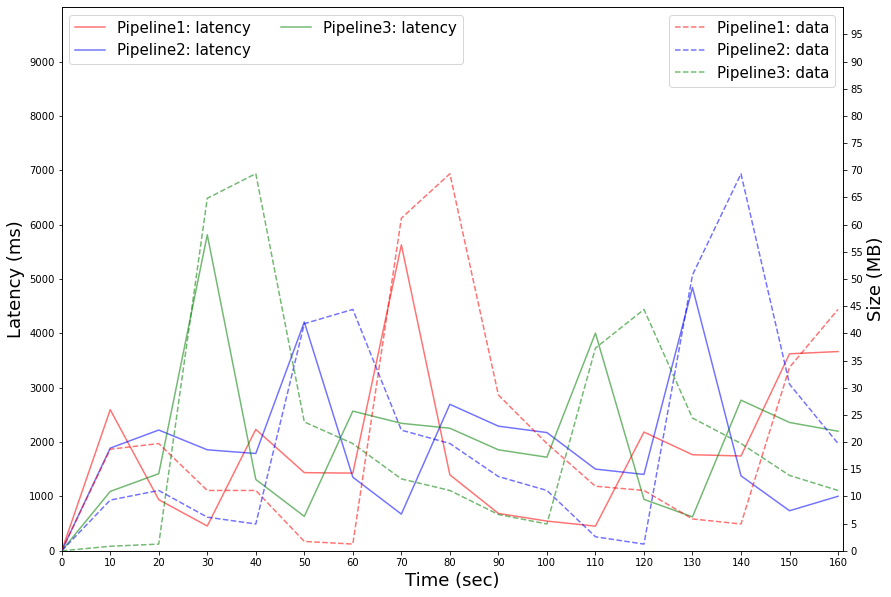

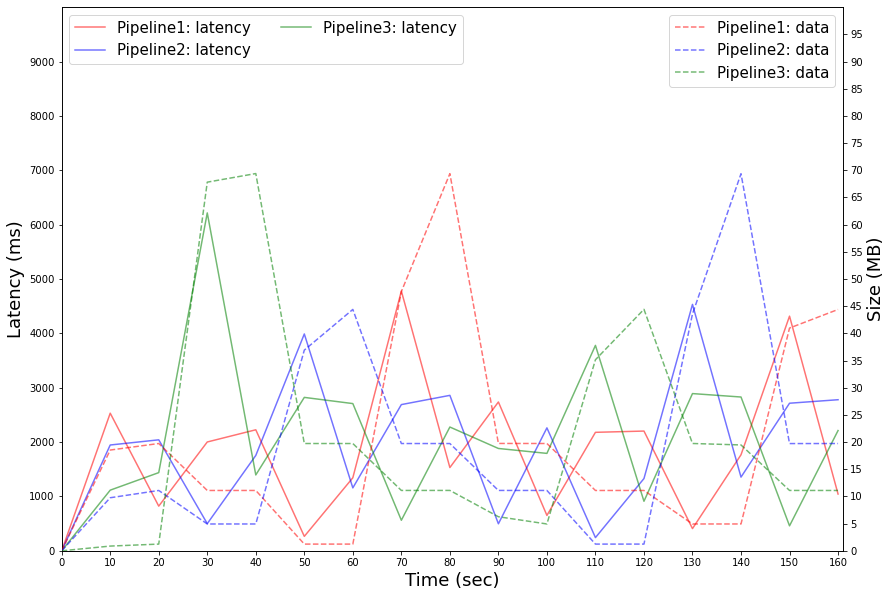

In [123]:
x = [i*10 for i in range(0,len(averages_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = averages_dict[scenario][0]['Size (MB)']
    p2_byte = averages_dict[scenario][1]['Size (MB)']
    p3_byte = averages_dict[scenario][2]['Size (MB)']
    p1_lat = averages_dict[scenario][0]['Latency (ms)']
    p2_lat = averages_dict[scenario][1]['Latency (ms)']
    p3_lat = averages_dict[scenario][2]['Latency (ms)']
    
    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)
    
    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
        
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)

# Extract Single Pipeline Data

In [128]:
dat_folder = 'data/'
files = ['birex-1pipeline.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 1
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r'\b(cloud|edge)\b'



for i in range(0,len(files)): 
    run = [[]]
    data[scenarios[i]] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                data[scenarios[i]] += [run]
                run = [[]]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                lat,size = values[0][0],values[0][1] 
                zone = zones[0]
                size /= 10**6
                run[0] += [(lat,size,zone)]


for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario

# Extract Error Probability

In [186]:
sizes = [[80, 60, 20, 140, 80, 60, 40, 120], [60, 40, 120, 80, 60, 20, 140, 80], [20, 140, 80, 60, 40, 120, 80, 60]]
errors = {20:0, 40:0, 60:0, 80:0, 120:0, 140:0}
total = {20:0, 40:0, 60:0, 80:0, 120:0, 140:0}

files = ['birex-1pipeline.txt', 'birex-byte-policy-20runs.txt', 'birex-latency-policy-20runs.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
threshold = 0.75
header_size = 3500

for scenario in scenarios:
    dfs = dfs_dict[scenario]
    #print(scenario + " " + str(len(dfs)))
    for df_list in dfs:
        pipeline_index = 0
        for pipeline in df_list:
            s_index = 0
            for i in range(1,len(pipeline) - 1,2):
                c = pipeline.iloc[i]
                n = pipeline.iloc[i+1]
                v1 = c['Size (MB)']
                l1 = c['Latency (ms)']
                z1 = c['Zone']
                v2 = n['Size (MB)']
                l2 = n['Latency (ms)']
                z2 = n['Zone']
                total[s_id] += 2
                s_id = sizes[pipeline_index][(i-1)//2]
                similarity = min(v1,v2)/max(v1,v2)
                diff = abs(v1-v2) 
                print(str(s_id) + " " + str(v1) + " " + str(v2) + " " + str(similarity) + " " + str(l2) )#" diff: " + str(similarity < threshold))# + " err: " + str(err > .2 and diff > threshold))
                if similarity < threshold and abs(v1-v2) > 1: #an error is considered as something that makes the behaviour of the system diverge, e.g. the simulation swaps the real-world implementation does not
                    errors[s_id] += 1
            pipeline_index += 1
            #print("-----")
        #print("---end run---")
result = {key: round(100*errors[key] / total[key], 3) for key in total.keys() if key in total}

print("errors----------->" + str(errors))
print("total------------>" + str(total))
print("error %---------->" + str(result))


#sizes = [[80, 60, 20, 140, 80, 60, 40, 120], [60, 40, 120, 80, 60, 20, 140, 80], [20, 140, 80, 60, 40, 120, 80, 60]];



80 19.729066666666668 19.7728 0.9977882073690457 521.5
60 11.1156 11.115 0.9999460218071898 2159.0
20 1.232 1.2344 0.9980557355800389 1341.0
140 35.3337 69.3225 0.5097003137509466 1514.0
80 32.122625 19.7248 0.6140469528875675 655.0
60 11.1072 11.097 0.999081676750216 2092.0
40 4.9272 4.9216 0.998863451859068 1587.5
120 44.448 44.496 0.9989212513484358 1425.0
80 19.739733333333334 19.7184 0.998919269426132 575.0
60 11.1024 11.0988 0.9996757457846953 2149.0
20 1.2348 1.2344 0.9996760609005507 1414.0
140 35.36705 69.4575 0.509189792319044 1283.0
80 32.1154 19.7296 0.6143345560073984 501.75
60 11.1084 11.106 0.9997839472831371 2046.0
40 4.9336 4.9352 0.9996757983465716 1758.0
120 44.424 44.3664 0.9987034035656401 1153.0
80 19.712 19.7664 0.9972478549457665 669.5
60 11.1048 11.1024 0.9997838772422737 2347.0
20 1.2306 1.2308 0.9998375040623985 1525.0
140 35.29995 69.2775 0.5095442243152539 1617.0
80 32.114525 19.739733333333334 0.6146668317010242 549.3333333333334
60 11.0976 11.1006 0.99972

80 19.73333333333333 19.7184 0.9992432432432433 2514.0
60 13.2641 11.1084 0.8374786076703282 2166.0
20 3.6974 1.2325333333333333 0.3333513640215647 1430.6666666666667
140 46.70883333333334 69.525 0.6718278796595949 1562.0
80 19.736 19.7568 0.9989471979267899 2497.0
20 0.83124 1.2332 0.6740512487836522 1440.6666666666667
140 69.3675 69.525 0.9977346278317152 1307.5
80 19.7264 19.7504 0.9987848347375244 2705.0
60 15.4185 11.0853 0.7189609884229984 2158.5
40 6.4803 4.938133333333333 0.7620223343569484 1676.0
120 31.215466666666668 44.4096 0.7028990728731326 904.5
80 25.9252 19.712 0.7603412895561076 2666.0
60 13.2553 11.1072 0.8379440676559565 2391.0
80 19.739733333333334 19.7344 0.9997298173565331 684.0
60 11.097 11.1096 0.9988658457550226 2177.0
20 1.2330666666666668 1.2338 0.999405630302048 1335.5
140 69.39 69.3675 0.9996757457846953 1659.0
80 19.7216 19.729066666666668 0.9996215397923874 397.0
60 13.259 11.1078 0.837755486839128 2362.5
40 4.9376 4.9344 0.999351911860013 1836.5
120 31.

40 4.936 4.9296 0.9987034035656401 1565.0
120 34.5248 44.424 0.777165496128219 1309.0
60 7.410834 11.0976 0.667787089100346 2105.6666666666665
40 4.936 4.9392 0.9993521218011014 1763.5
120 24.6584 44.41248 0.5552133094121292 5254.2
80 19.7312 19.7248 0.9996756406097955 3192.0
60 11.1096 11.1042 0.9995139338950098 2383.5
20 1.2338 1.236 0.9982200647249191 1401.0
140 69.33375 69.435 0.998541801685029 1285.0
80 19.7376 19.7056 0.998378728923476 2823.3333333333335
20 0.829625 1.2336 0.6725235084306095 1511.0
140 35.36805 69.39 0.5096995244271508 1569.5
80 19.7632 19.712 0.9974093264248703 571.0
60 11.1114 11.1024 0.9991900210594524 2477.3333333333335
40 4.928 4.9324 0.9991079393398751 1767.0
120 31.253333333333334 44.352 0.7046657046657048 769.0
80 19.76 19.720533333333332 0.9980026990553305 2787.3333333333335
60 11.097 11.0988 0.9998378203048978 2622.0
80 19.729066666666668 19.7632 0.998272884283247 614.0
60 11.097 11.1 0.9997297297297297 2273.6666666666665
20 1.2344 1.236 0.9987055016181

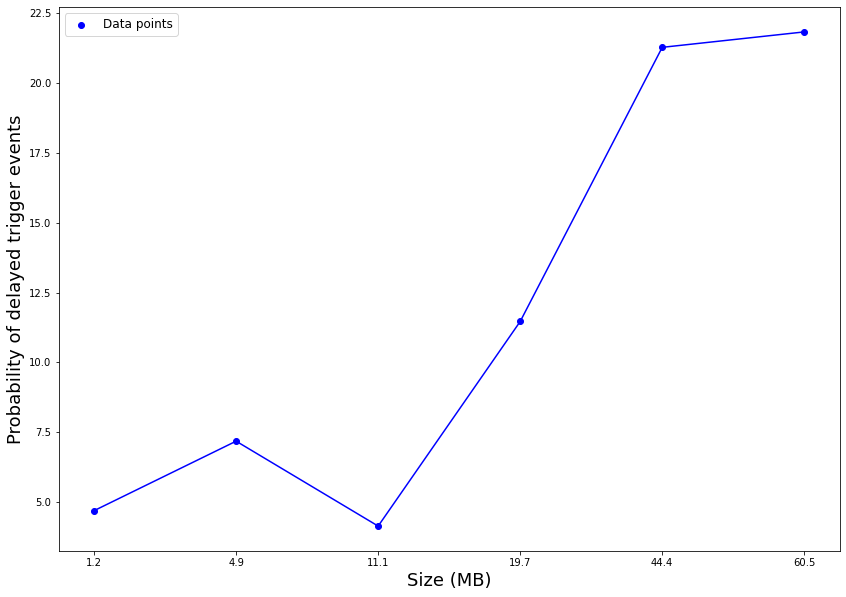

In [184]:
x = ['1.2', '4.9', '11.1', '19.7', '44.4', '60.5']
y = list(result.values()) 

fig = plt.figure(figsize=(14, 10))

plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y, color='blue') 

plt.legend(loc='upper left', fontsize=12)

plt.xlabel('Size (MB)', fontsize=18)
plt.ylabel('Probability of delayed trigger events', fontsize=18)
plt.grid(False)
plt.show()

fig.savefig(f'images/err_distribution.pdf', dpi=100)
#fig.savefig(f'../phd-thesis/figures/err_distribution.pdf', dpi=100)

# Extract the function to approximate the graph

In [158]:
# Extract x and y values
x_values = np.array(list(result.keys()))
y_values = np.array(list(result.values()))

# Fit a polynomial to the data
coefficients = np.polyfit(x_values, y_values, 5)
f = np.poly1d(coefficients)

# Print the polynomial function
print(f)

           5             4            3          2
5.706e-08 x - 2.344e-05 x + 0.003535 x - 0.2378 x + 7.024 x - 65.38


# Extract ABS data for plot (probabilistic delay)

In [108]:
dat_folder = 'data/'
files = ['3-pipelines-size-policy_with_error.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"


swaps_dict = {}

for i in range(0,len(files)): 
    scenario = scenarios[i]
    run = [[] for _ in range(0,n_pipelines)]
    data[scenario] = []
    swaps_dict[scenario] = [0 for _ in range(0,n_pipelines)]
    last = ['cloud' for _ in range(0,n_pipelines)]
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                last = ['cloud' for _ in range(0,n_pipelines)]
                data[scenarios[i]] += [run]
                run = [[] for _ in range(0,n_pipelines)]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                for j in range(0,len(values)):
                    lat,size = values[j][0],values[j][1] 
                    zone = zones[j]
                    if zone != last[j]:
                        swaps_dict[scenario][j] += 1
                        last[j] = zone
                    run[j] += [(lat,size,zone)]
                
for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario

averages_dict = {}

for scenario in scenarios:
    averages_dict[scenario] = []
    for i in range(n_pipelines):
        p = [run[i] for run in dfs_dict[scenario]]  
        averages_dict[scenario] += [pd.concat(p).groupby(level=0).mean()]


for scenario in swaps_dict:
    avg_swaps_dict[scenario] = [value / len(dfs_dict[scenario]) for value in swaps_dict[scenario]]
    
    
print(avg_swaps_dict)

{'birex-byte-policy-20runs': [4.2, 3.2, 4.0], 'birex-latency-policy-20runs': [11.0, 10.0, 8.0], '3-pipelines-size-policy_with_error': [4.0, 3.0, 4.0]}


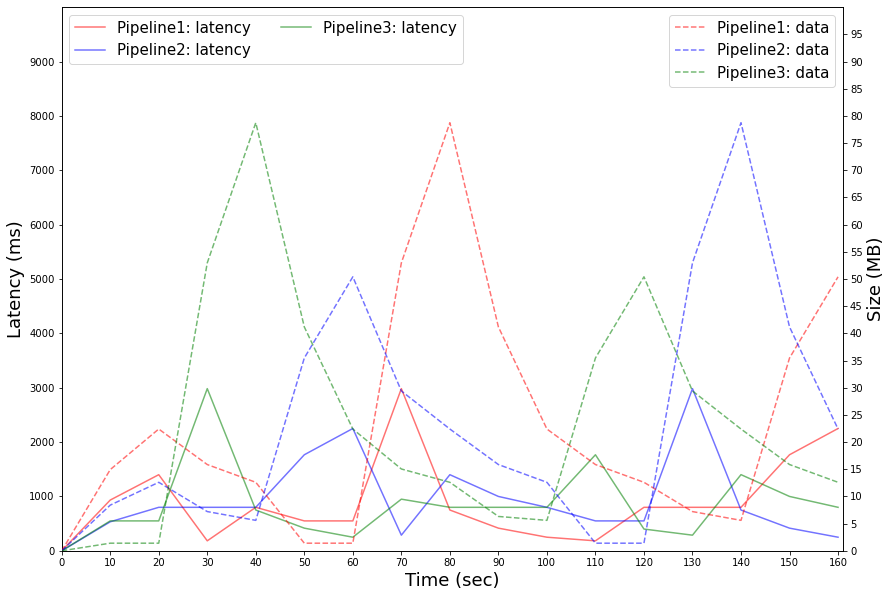

In [109]:
x = [i*10 for i in range(0,len(averages_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = averages_dict[scenario][0]['Size (MB)']
    p2_byte = averages_dict[scenario][1]['Size (MB)']
    p3_byte = averages_dict[scenario][2]['Size (MB)']
    p1_lat = averages_dict[scenario][0]['Latency (ms)']
    p2_lat = averages_dict[scenario][1]['Latency (ms)']
    p3_lat = averages_dict[scenario][2]['Latency (ms)']
    
    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)
    
    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
        
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)
    #fig.savefig(f'../phd-thesis/figures/{scenario}.pdf', dpi=100)

In [ ]:
            
            for i, r in pipeline.iterrows():
                if i > s_index:
                    v = r['Size (MB)']
                    l = r['Latency (ms)']
                    z = r['Zone']
                    s_id = sizes[pipeline_index][(s_index//2)]
                    total[s_id] += 1
                    t_size = (10**-6) * header_size * s_id ** 2
                    diff = abs(v-t_size)#/t_size#abs(v - t_size)
                    err =  diff / t_size
                    s_index += 1
                    #print(z + " " + str(s_id) + " " + str(v) + " " + str(t_size) + " err: " + str(err > .2 and diff > threshold))
                    print(str(v) + " " + str(t_size) + " " + str(diff))# + " err: " + str(err > .2 and diff > threshold))
                    if err > .2 and diff > threshold: #an error is considered as something that makes the behaviour of the system diverge, e.g. the simulation swaps the real-world implementation does not
                        errors[s_id] += 1